# Import : by GitHub

You can try this code in Colab by this method.  

In [1]:
!git clone https://github.com/KanghwaSisters/24_2_mainSession.git

Cloning into '24_2_mainSession'...
remote: Enumerating objects: 288, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 288 (delta 81), reused 67 (delta 40), pack-reused 148 (from 1)
Receiving objects: 100% (288/288), 1.29 MiB | 3.37 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [2]:
import os
os.chdir('/content/24_2_mainSession/4주차/env')

In [3]:
! python GridWorldEnvironment.py

In [4]:
from GridWorldEnvironment import GridWorldEnvironment

# Deep SARSA Class

In [5]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [32]:
# 딥살사 인공신경망
class DeepSARSA(nn.Module):
    def __init__(self, state_size, action_size):
        super(DeepSARSA, self).__init__()
        self.fc1 = nn.Linear(state_size, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc_out = nn.Linear(30, action_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q

In [33]:
class DeepSARSAgent:
    def __init__(self, state_size, action):
        # 행동
        self.action_spaces = action
        self.num_actions = len(self.action_spaces)
        # 상태(교재와 동일)
        self.learning_rate = 0.001
        self.discount_factor = 0.99
        self.epsilon = 1. # 탐험-탐사 비율 (처음에는 탐험 많이 하도록 1로 설정)
        self.epsilon_decay = 0.999 # 탐험 비율 감소 속도 (학습이 진행됨에 따라 점차 감소)
        self.epsilon_min = 0.01 # 탐험 비율의 최솟값
        self.model = DeepSARSA(state_size, self.num_actions)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    # 입실론 탐욕 정책에 따라서 행동을 선택
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.num_actions)
        else:
            # 큐함수에 따른 행동 반환
            state = torch.tensor(state, dtype=torch.float32)
            q_values = self.model(state)
            return torch.argmax(q_values).item()

    # 샘플을 가지고 인공신경망을 업데이트
    def train_model(self, state, action, reward, next_state, next_action, done):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay # epsilon 값을 줄여나감
            '''
            이유
            초반에는 에이전트가 탐험을 통해 다양한 상황에 대해서 학습하고 학습이 이루어진 후에는 예측하는대로 에이전트가 움직이기 위해서
            '''
        # 학습 파라미터
        state = torch.tensor(state, dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32)

        predict = self.model(state) # 현재 상태에서의 예측 Q값
        one_hot_action = F.one_hot(torch.tensor(action), num_classes=self.num_actions).float() # 실제로 한 행동에 해당하는 값만 추출하기 위해
        pred = torch.sum(predict * one_hot_action) # 실제 행동에 대한 모델의 출력만 남겨놓을 수 있음

        next_q = self.model(next_state)[next_action].item()
        target = reward + (1 - done) * self.discount_factor * next_q

        # MSE 오류함수 계산
        mse = nn.MSELoss()
        loss = mse(pred, torch.tensor(target))

        # 오류함수를 줄이는 방향으로 모델 업데이트
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Main

- **SARSA**를 이용해 그리드 월드 학습시키기  
- 학습 지표 시각화

In [34]:
env = GridWorldEnvironment(start_point=(0,0),
                           end_point=(4,4),
                           gridworld_size=(5,5))
agent = DeepSARSAgent(env.state_len, env.action_space)
EPISODES = 1000
RENDER_PROCESS = False # 학습 중 실시간 rendering
RENDER_END = False # 에피소드 종료 후 상태 rendering
total = []

In [35]:
for episode in range(EPISODES):
    # 게임 환경과 상태를 초기화
    state = env.reset()
    # 현재 상태에 대한 행동을 선택
    action_idx = agent.get_action(state)
    num = 0
    done = False

    while not done:
        if RENDER_PROCESS:
            env.render()

        # 행동을 취한 후 다음 상태 보상 에피소드의 종료 여부를 받아옴
        next_state, reward, done = env.step(action_idx)
        # 다음 상태에서의 다음 행동을 선택
        next_action_idx = agent.get_action(next_state)
        agent.train_model(state, action_idx, reward, next_state, next_action_idx, done)

        state = next_state
        action_idx = next_action_idx
        num += 1

    total.append(num)
    if (episode+1) % 100 == 0:
        print(f"[Episode]: {episode+1}/{EPISODES} | [mean]:{np.mean(total[episode-99:]):.1f} | [Epsilon]: {agent.epsilon:.3f}")

    if RENDER_END:
        env.render()

[Episode]: 100/1000 | [mean]:36.3 | [Epsilon]: 0.026
[Episode]: 200/1000 | [mean]:8.9 | [Epsilon]: 0.011
[Episode]: 300/1000 | [mean]:8.5 | [Epsilon]: 0.010
[Episode]: 400/1000 | [mean]:11.6 | [Epsilon]: 0.010
[Episode]: 500/1000 | [mean]:9.6 | [Epsilon]: 0.010
[Episode]: 600/1000 | [mean]:9.7 | [Epsilon]: 0.010
[Episode]: 700/1000 | [mean]:10.8 | [Epsilon]: 0.010
[Episode]: 800/1000 | [mean]:11.2 | [Epsilon]: 0.010
[Episode]: 900/1000 | [mean]:9.8 | [Epsilon]: 0.010
[Episode]: 1000/1000 | [mean]:10.3 | [Epsilon]: 0.010


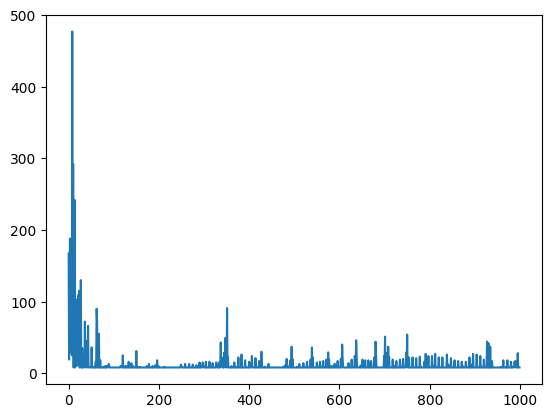

In [36]:
import matplotlib.pyplot as plt
plt.plot(total)

In [37]:
# 최종 결과
env.render()

S . . . . 
X . . . . 
X . . . . 
X . . . . 
X X X X A 

